<a href="https://colab.research.google.com/github/kevinliao2003/Advocacy-Project/blob/main/Image_Classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile

if not os.path.isfile('./data.tar.gz'):
    !wget 'http://cs.umd.edu/~pulkit/hw_3_data.tar.gz' -O data.tar.gz

with tarfile.open('./data.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./')


--2024-05-03 02:46:59--  http://cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving cs.umd.edu (cs.umd.edu)... 128.8.127.4
Connecting to cs.umd.edu (cs.umd.edu)|128.8.127.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz [following]
--2024-05-03 02:46:59--  http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving www.cs.umd.edu (www.cs.umd.edu)... 128.8.127.4
Reusing existing connection to cs.umd.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 7171530 (6.8M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   6.84M  4.47MB/s    in 1.5s    

2024-05-03 02:47:00 (4.47 MB/s) - ‘data.tar.gz’ saved [7171530/7171530]



In [ ]:
import os
import pandas as pd
from collections import Counter
from PIL import Image

def analyze_dataset(csv_file):
    data_df = pd.read_csv(csv_file)

    # Analyze class distribution
    class_counts = Counter(data_df['class_name'])
    print("Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    # Get the first image path directly from the CSV
    example_image_path = data_df.iloc[0]['image_path']
    with Image.open(example_image_path) as img:
        print(f"Image Dimensions: {img.size}, Channels: {img.mode}")

    # Inspect sample images directly from the CSV
    sample_images = data_df['image_path'].sample(3)
    for img_path in sample_images:
        print(f"Sample Image: {img_path}")
        with Image.open(img_path) as img:
            img.show()

# Example usage
analyze_dataset('data/csvs/train.csv')


Class Distribution:
cat: 300
lemon: 300
basketball: 300
pretzel: 300
umbrella: 300
dog: 300
bear: 300
bus: 300
pizza: 300
guinea_pig: 300
Image Dimensions: (64, 64), Channels: RGB
Sample Image: data/train/qduaoqrp.JPEG
Sample Image: data/train/em3x7clj.JPEG
Sample Image: data/train/17bzaalx.JPEG


### Dataset class

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
import torchvision
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, csv_path, data_root, transform=None, device='gpu'):
        self.transform = transform
        self.root_path = data_root
        self.device = device

        # Read the CSV file
        data = pd.read_csv(csv_path)

        # Get the image paths from the CSV
        self.image_paths = [os.path.join(self.root_path, img_path) for img_path in data['image_path']]

        # Get the class ids if they exist in the CSV
        if 'class_id' in data.columns:
            self.class_ids = data['class_id'].tolist()
        else:
            self.class_ids = None

        # Get the image names from the CSV
        self.image_names = data['image_name'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        rel_img_path = self.image_paths[idx]
        image_name = self.image_names[idx]

        # Read the image file
        img = read_image(rel_img_path, mode=torchvision.io.image.ImageReadMode.RGB)

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        # Return based on whether the dataset is for testing or training
        if self.class_ids is None:
            return img, image_name, rel_img_path
        else:
            class_id = torch.tensor(self.class_ids[idx], dtype=torch.long)
            return img.to(self.device), class_id.to(self.device)


cuda available


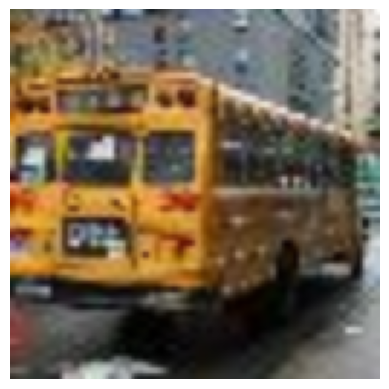

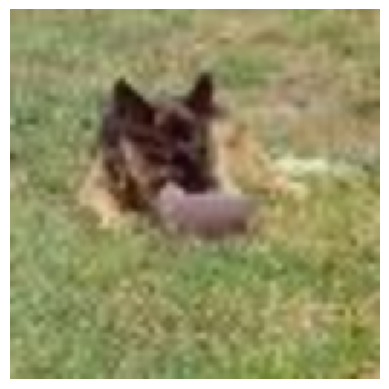

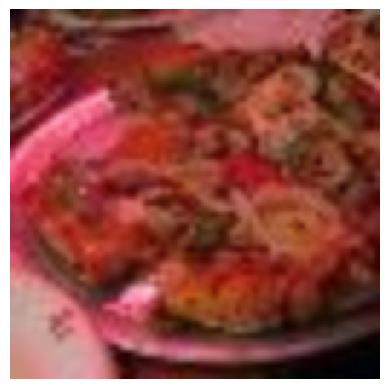

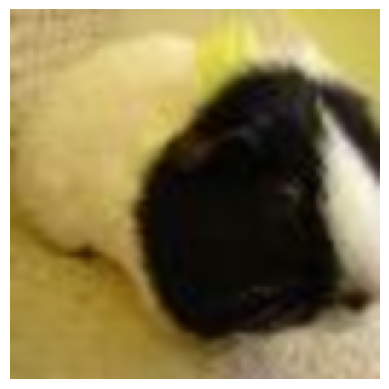

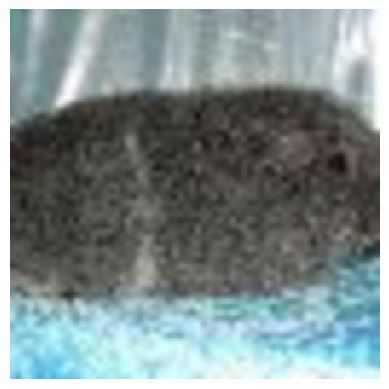

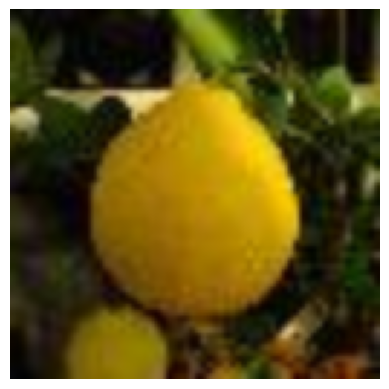

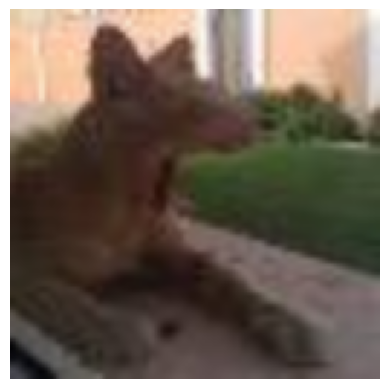

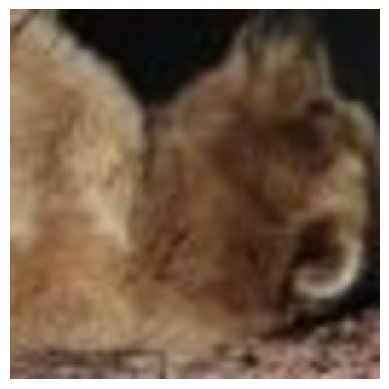

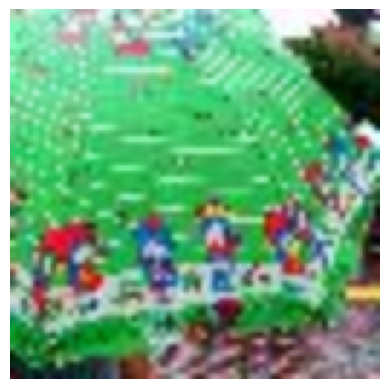

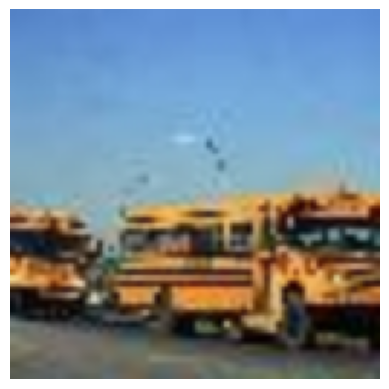

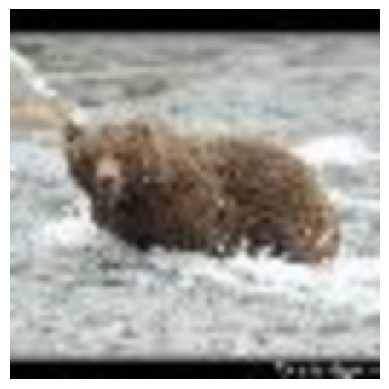

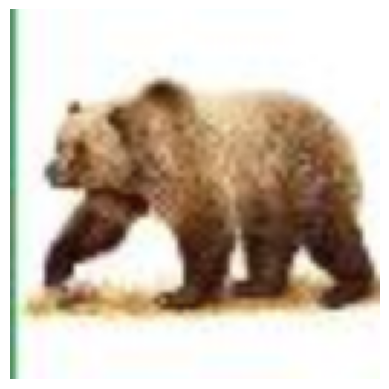

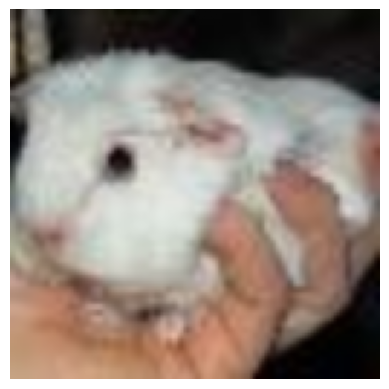

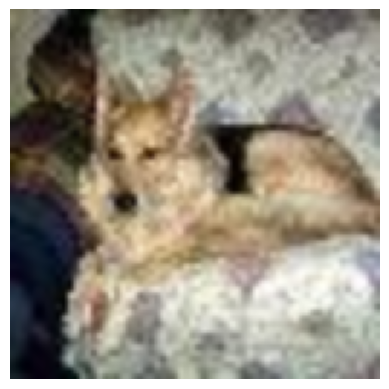

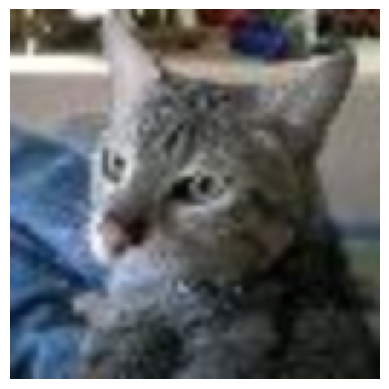

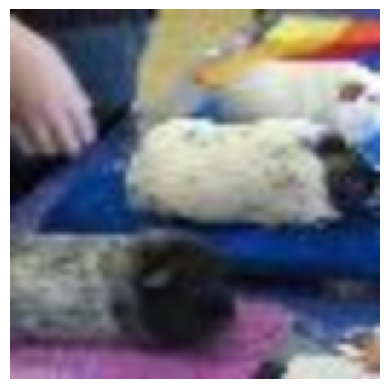

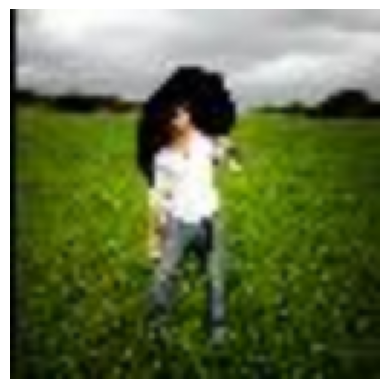

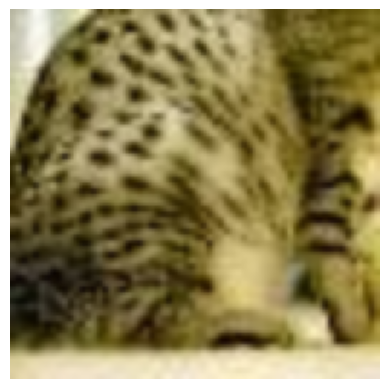

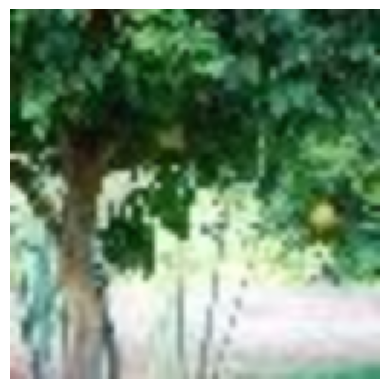

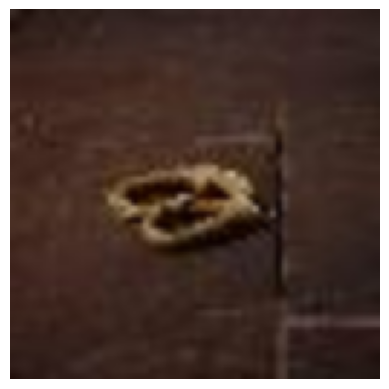

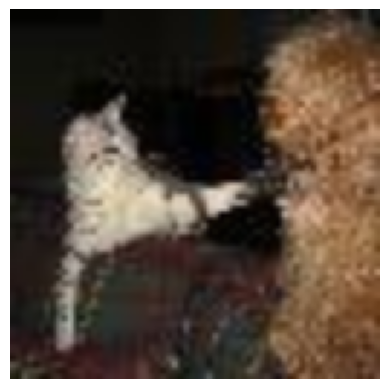

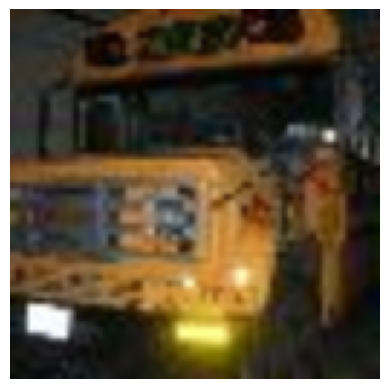

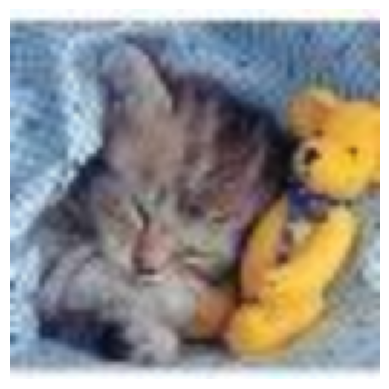

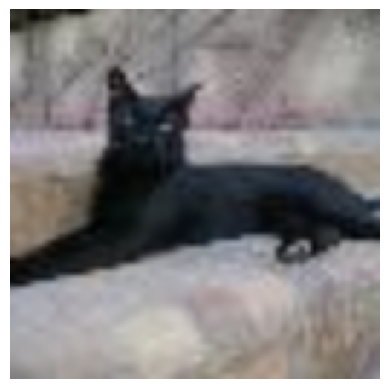

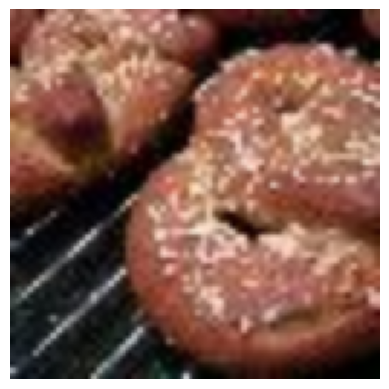

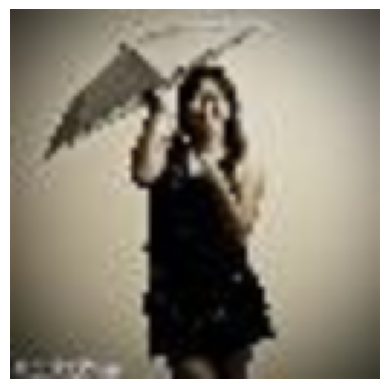

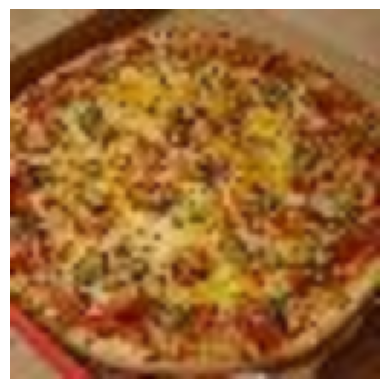

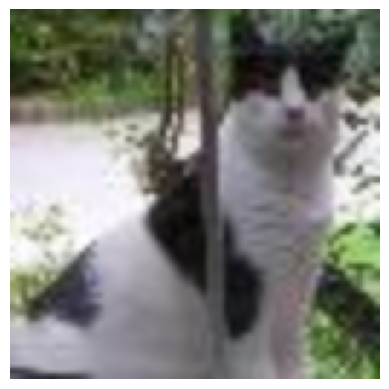

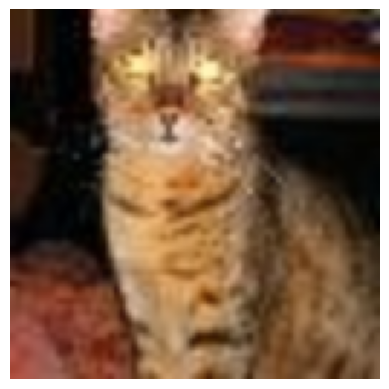

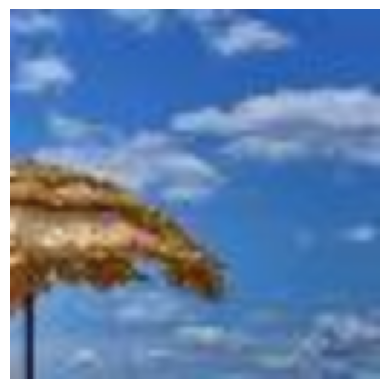

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms as T

def plot_image(img, title=None):
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)), # Resize images to 128x128
    transforms.ToTensor() # Convert images to PyTorch tensors
])

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Create an instance of the CustomImageDataset class for the training dataset
dataset = CustomImageDataset(csv_path='/content/data/csvs/test.csv', data_root='.', transform=transform, device=device)

# Show the first 3 images from the dataset
for i in range(30):
    img, _, _= dataset[i]

    img = img.permute(1, 2, 0) # Rearrange dimensions for visualization
    plot_image(img)

In [ ]:
len(dataset)

1500

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 16

learning_rate = 1e-6

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_root = "./"

# Create an instance of the CustomImageDataset class for the training and validation datasets
train_set = CustomImageDataset(csv_path='data/csvs/train.csv', data_root=img_root, transform=transform, device=device)
val_set = CustomImageDataset(csv_path='data/csvs/val.csv', data_root=img_root, transform=transform, device=device)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
print('val_loader')

# Initialize your model
n_classes = 10
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

# Initialize the optimizer.
optimizer = Adam(model.parameters(), lr=learning_rate)

# Instantiate the loss function.
loss_fn = nn.CrossEntropyLoss().to(device)

n_epochs = 60
val_loss_values = []
training_loss_values = []
eval_epochs = []

patience = 5
# Initialize a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5)

best_val_loss = float('inf')
trigger_times = 0

for epoch in range(n_epochs):
    print(f'epoch {epoch}')

    # Training Phase
    model.train()
    total_train_loss = 0
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation Phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            img, label = img.to(device), label.to(device)
            pred = model(img)
            val_loss = loss_fn(pred, label)
            total_val_loss += val_loss.item()

    val_loss_avg = total_val_loss / len(val_loader)
    scheduler.step(val_loss_avg)

    # Early stopping logic
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        torch.save(model.state_dict(), "model_best.pth")
        trigger_times = 0
        print_this = 1
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping triggered!")
        break

    print(f"Epoch {epoch}: Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {val_loss_avg:.4f}")
    if print_this == 1:
      print("Best Model")
      print_this = 0
    eval_epochs.append(epoch)
    training_loss_values.append(total_train_loss / len(train_loader))
    val_loss_values.append(val_loss_avg)

# Save final model weights
torch.save(model.state_dict(), "model.pth")

val_loader
epoch 0


100%|██████████| 32/32 [00:04<00:00,  7.17it/s]


Epoch 0: Train Loss: 2.2830, Val Loss: 2.2571
Best Model
epoch 1


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 1: Train Loss: 2.2129, Val Loss: 2.1673
Best Model
epoch 2


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


Epoch 2: Train Loss: 2.1502, Val Loss: 2.1046
Best Model
epoch 3


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 3: Train Loss: 2.0804, Val Loss: 2.0213
Best Model
epoch 4


100%|██████████| 32/32 [00:04<00:00,  7.17it/s]


Epoch 4: Train Loss: 1.9931, Val Loss: 1.9250
Best Model
epoch 5


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch 5: Train Loss: 1.9148, Val Loss: 1.8226
Best Model
epoch 6


100%|██████████| 32/32 [00:04<00:00,  7.12it/s]


Epoch 6: Train Loss: 1.8157, Val Loss: 1.7251
Best Model
epoch 7


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


Epoch 7: Train Loss: 1.7328, Val Loss: 1.6342
Best Model
epoch 8


100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


Epoch 8: Train Loss: 1.6527, Val Loss: 1.6054
Best Model
epoch 9


100%|██████████| 32/32 [00:04<00:00,  7.17it/s]


Epoch 9: Train Loss: 1.5926, Val Loss: 1.4974
Best Model
epoch 10


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch 10: Train Loss: 1.5132, Val Loss: 1.4112
Best Model
epoch 11


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Epoch 11: Train Loss: 1.4549, Val Loss: 1.3581
Best Model
epoch 12


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 12: Train Loss: 1.3807, Val Loss: 1.3258
Best Model
epoch 13


100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Epoch 13: Train Loss: 1.3440, Val Loss: 1.2367
Best Model
epoch 14


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 14: Train Loss: 1.3059, Val Loss: 1.2029
Best Model
epoch 15


100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


Epoch 15: Train Loss: 1.2527, Val Loss: 1.1346
Best Model
epoch 16


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


Epoch 16: Train Loss: 1.2227, Val Loss: 1.1101
Best Model
epoch 17


100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch 17: Train Loss: 1.1736, Val Loss: 1.1148
epoch 18


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Epoch 18: Train Loss: 1.1594, Val Loss: 1.0482
Best Model
epoch 19


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 19: Train Loss: 1.1205, Val Loss: 0.9657
Best Model
epoch 20


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 20: Train Loss: 1.1359, Val Loss: 0.9990
epoch 21


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Epoch 21: Train Loss: 1.0593, Val Loss: 1.0019
epoch 22


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


Epoch 22: Train Loss: 1.0598, Val Loss: 0.9150
Best Model
epoch 23


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch 23: Train Loss: 1.0481, Val Loss: 0.9622
epoch 24


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 24: Train Loss: 1.0205, Val Loss: 0.9583
epoch 25


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Epoch 25: Train Loss: 0.9903, Val Loss: 0.9294
epoch 26


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch 26: Train Loss: 0.9985, Val Loss: 0.8518
Best Model
epoch 27


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


Epoch 27: Train Loss: 1.0063, Val Loss: 0.8696
epoch 28


100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Epoch 28: Train Loss: 0.9567, Val Loss: 0.8072
Best Model
epoch 29


100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch 29: Train Loss: 0.9494, Val Loss: 0.8691
epoch 30


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


Epoch 30: Train Loss: 0.9255, Val Loss: 0.8186
epoch 31


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


Epoch 31: Train Loss: 0.9323, Val Loss: 0.8520
epoch 32


100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


Epoch 32: Train Loss: 0.9132, Val Loss: 0.8304
epoch 33


100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 33: Train Loss: 0.8989, Val Loss: 0.7960
Best Model
epoch 34


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


Epoch 34: Train Loss: 0.8828, Val Loss: 0.8183
epoch 35


100%|██████████| 32/32 [00:04<00:00,  7.24it/s]


Epoch 35: Train Loss: 0.8574, Val Loss: 0.8407
epoch 36


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


Epoch 36: Train Loss: 0.8689, Val Loss: 0.7555
Best Model
epoch 37


100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


Epoch 37: Train Loss: 0.8606, Val Loss: 0.7756
epoch 38


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 38: Train Loss: 0.8606, Val Loss: 0.7852
epoch 39


100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Epoch 39: Train Loss: 0.8318, Val Loss: 0.7598
epoch 40


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


Epoch 40: Train Loss: 0.8065, Val Loss: 0.8116
epoch 41


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Epoch 41: Train Loss: 0.8405, Val Loss: 0.6809
Best Model
epoch 42


100%|██████████| 32/32 [00:04<00:00,  7.22it/s]


Epoch 42: Train Loss: 0.8680, Val Loss: 0.7451
epoch 43


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch 43: Train Loss: 0.8129, Val Loss: 0.7427
epoch 44


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


Epoch 44: Train Loss: 0.8069, Val Loss: 0.7201
epoch 45


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 45: Train Loss: 0.8252, Val Loss: 0.7394
epoch 46


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Early stopping triggered!


### Model definition

Define your image classifier model here. Since we're working with images, you should consider an convolution neural network type model architecture. Start simple and make it more complex if you need to once you have something working.

### Training

### Plot your training and validation loss

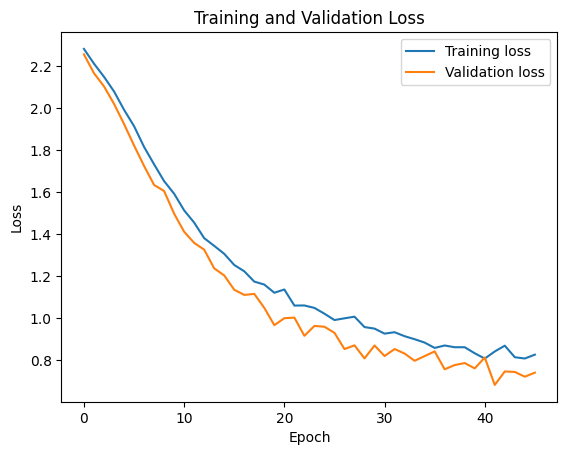

In [ ]:
# Plot the training and validation loss
plt.plot(eval_epochs, training_loss_values, label='Training loss')
plt.plot(eval_epochs, val_loss_values, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Test your model against the validation dataset
This should give you a rough idea on how your model will do on the test set that you don't have labels for.
This section is not required and is only provided as a sanity check for you

In [ ]:
import torch
from torchvision import models

# Load the pretrained ResNet model (e.g., resnet18)
model = models.resnet50(weights=None)
n_classes = 10  # Number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)

# Load the saved state dictionary
model_state_dict = torch.load("./model_best.pth")

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# set model to inference mode
model.eval()
batch_size = 1

# Load the validation dataset
test_dataset = CustomImageDataset(csv_path='data/csvs/val.csv', data_root=img_root, transform=transform, device=device)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

preds = []
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)  # Move the input data to device
        pred = model(img)
        _, pred_class = torch.max(pred, 1)
        preds.append(pred_class.item())


# Get the true labels for the validation dataset
true_labels = test_dataset.class_ids
print('true_labels', true_labels)

accuracy = (torch.tensor(true_labels) == torch.tensor(preds)).float().mean().item()
print(f"Accuracy: {accuracy}")


100%|██████████| 500/500 [00:08<00:00, 62.04it/s]

true_labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

### Evaluation
Evaluate your model on the test dataset and create a CSF file. This is the file you need to submit.
> Important: make sure the prediction file has the columns: image_name, prediction, image_path

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

# Load the pretrained ResNet model (e.g., resnet18)
model = models.resnet50(weights=None)
n_classes = 10  # Number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)

# Load the saved state dictionary
model_state_dict = torch.load("./model.pth")

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Move the model to the appropriate device
model.to(device)
model.eval()

# Load the test dataset
test_dataset = CustomImageDataset(csv_path='data/csvs/test.csv', data_root='./', transform=transform, device=device)
test_loader = DataLoader(test_dataset, batch_size=16)

# Make predictions on the test data and check for missing images
final_preds = []
missing_images = []
with torch.no_grad():
    for imgs, img_names, img_paths in tqdm(test_loader):
        imgs = imgs.to(device)
        preds = model(imgs)
        _, pred_classes = torch.max(preds, 1)

        # Save predictions for each image in the batch
        batch_preds = [
            (img_name, pred_class.item(), img_path)
            for img_name, pred_class, img_path in zip(img_names, pred_classes, img_paths)
        ]
        final_preds.extend(batch_preds)

# Log missing images
if missing_images:
    print(f"Missing Images: {len(missing_images)}")
    for missing_img in missing_images:
        print(missing_img)

# Check that the total predictions match the total dataset size
assert len(final_preds) == len(test_dataset), "Mismatch between predictions and dataset size!"

# Save predictions to a CSV file
df = pd.DataFrame(final_preds, columns=["image_name", "prediction", "image_path"])
df.to_csv("predictions.csv", index=False)


100%|██████████| 94/94 [00:13<00:00,  6.89it/s]


In [ ]:
# Load the CSV file to inspect its contents
import pandas as pd

df = pd.read_csv("predictions.csv")
print(df.head())
print(f"Total predictions: {len(df)}")  # Check number of predictions


      image_name  prediction                 image_path
0  1bhvafqv.JPEG           7  ./data/test/1bhvafqv.JPEG
1  vyiyc7y2.JPEG           6  ./data/test/vyiyc7y2.JPEG
2  r8z3as5n.JPEG           8  ./data/test/r8z3as5n.JPEG
3  udhyyuy0.JPEG           9  ./data/test/udhyyuy0.JPEG
4  i3dupi0m.JPEG           9  ./data/test/i3dupi0m.JPEG
Total predictions: 1500


In [ ]:
test_prediction = pd.DataFrame(final_preds, columns=['image_name', 'prediction', 'image_path'])
test_prediction.to_csv('prediction.csv')

# You can comment these lines out if you're running the notebook locally
from google.colab import files
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload *prediction.csv* on gradescope

Utility Functions to Inspect Database

In [ ]:
import os

train_path = 'data/train'
val_path = 'data/val'
csv_path = 'data/csvs'

def count_images(folder_path):
    return sum([len(files) for r, d, files in os.walk(folder_path)])

total_train = count_images(train_path)
total_val = count_images(val_path)
total_test = count_images(csv_path)

print(f"Total Images: Train = {total_train}, Val = {total_val}, Test = {total_test}")


In [ ]:
import os

def print_directory_structure(path, level=0):
    print(" " * (level * 2) + os.path.basename(path) + "/")
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            print_directory_structure(full_path, level + 1)
        else:
            print(" " * ((level + 1) * 4) + entry)

base_path = "./"  # Adjust to your base path
print_directory_structure(base_path)


In [ ]:
data_df = pd.read_csv('data/csvs/train.csv')
print(data_df.columns)
print(data_df['image_path'].head())


Index(['class_id', 'class_name', 'image_name', 'image_path'], dtype='object')
0    data/train/718jai12.JPEG
1    data/train/upajvagf.JPEG
2    data/train/u3di1s04.JPEG
3    data/train/8p2hg2ln.JPEG
4    data/train/98em9mks.JPEG
Name: image_path, dtype: object
